<a href="https://colab.research.google.com/github/ugurtegin/MMF_RNN_Reuse/blob/main/GRIN_BPM_SC3HighRes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Load Libraries


In [ ]:
from google.colab import drive

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy.io as sio
import time

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


# Super Gaussian for boundary

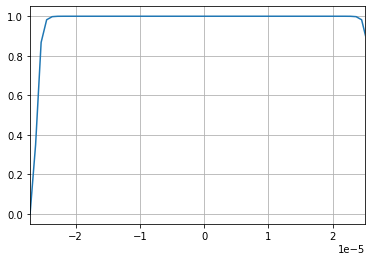

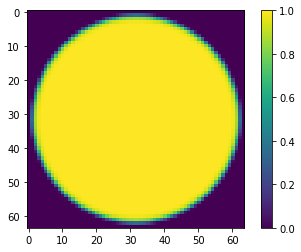

In [ ]:
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1,p=60,w=26.5e-6):
  """define normalized 2D gaussian"""

  return np.exp(-2*((np.sqrt(x**2+y**2)/w)**p))

spacewidth=54.1442e-6

xres=54.1442e-6/64
x = np.linspace(-spacewidth*0.5,spacewidth*0.5,int(spacewidth/xres))

x1, y1 = np.meshgrid(x, x) # get 2D variables instead of 1D
z = gaus2d(x1, y1)

# plt.imshow(z)
# plt.colorbar()

plt.plot(x,z[32,:])
plt.grid()
plt.xlim((-27.0721e-6,25e-6))
plt.show()

cp_super_gauss2d =cp.asarray(z)
cp_super_gauss2d = cp.repeat(cp_super_gauss2d[:,:,cp.newaxis], 2**10, axis=2)

plt.imshow(z)
plt.colorbar()
plt.show()



In [ ]:
def average(arr, n):
    end =  n * int(len(arr)/n)
    return np.mean(arr[:end].reshape(-1, n), 1)

# BPM 


In [ ]:
tt = time.time()
c = 299792458 # [m/s]
n0 = 1.45                   # Refractive index of medium (1.44 for 1550 nm, 1.45 for 1030 nm)
lambda_c = 1030e-9          # Central wavelength of the input pulse in [m]

## TIME SPACE DOMAIN
timewidth = 1.8e-12          # Width of the time window in [s]
tres = timewidth/((2**10))
t = cp.arange(-timewidth*0.5,(timewidth*0.5),tres)
#t = -timewidth*0.5:tres:timewidth*0.5 # Time in [s]
timesteps=len(t)

spacewidth=54.1442e-6
xres = spacewidth/((2**6))
#x = -spacewidth*0.5:xres:spacewidth*0.5 # Time in [s]
x = cp.arange(-spacewidth*0.5,(spacewidth*0.5),xres)
xsteps=len(x)
y = x
[X,Y,T] = cp.meshgrid(x,y,t)

## FOURIER DOMAIN
fs=1/timewidth
freq = c/lambda_c+fs*cp.linspace(-timesteps/2,timesteps/2,num = timesteps)
#freq=c/lambda_c+fs*linspace(-(timesteps-1)/2,(timesteps-1)/2,timesteps) # [Hz]
wave=c/freq # [m]
w=2*cp.pi*c/lambda_c # [Hz]
omegas=2*cp.pi*freq
wt = omegas-w

#kx = 2*pi/xsteps/xres*x;
#kx = 2*pi/xres*x;

#CHECK KX
a = cp.pi/xres  # grid points in "frequency" domain--> {2*pi*(points/mm)}
N = len(x)
zbam = cp.arange(-a,(a-2*a/N)+(2*a/N),2*a/N)
kx = cp.transpose(zbam) # "frequency" domain indexing ky = kx; 
ky = kx
[KX,KY,WT] = cp.meshgrid(kx,ky,wt);

## OPERATORS
k0 = w*n0/c
n2 = 3.2e-20       #Kerr coefficient (m^2/W)
R = 25e-6
beta2 = 24.8e-27
beta3 = 23.3e-42
gamma = (2*cp.pi*n2/(lambda_c))
delta = 0.01
NL1 = -1j*((k0*delta)/(R*R))*((X**2)+(Y**2))

D1 = (0.5*1j/k0)*((-1j*(KX))**2+(-1j*(KY))**2)
D2 = ((-0.5*1j*beta2)*(-1j*(WT))**2)+((beta3/6)*(-1j*(WT))**3)
D = D1 + D2
s_imgper = (cp.pi*R)/cp.sqrt(2*delta)
dz = s_imgper/100
DFR = cp.exp(D*dz/2)

## INPUT 
flength = s_imgper*3
fstep = flength/dz
x_fwhm = 25e-6
t_fwhm = 100e-15
#Ppeak = 10e6 # W
Ppeak = cp.linspace(4e6, 40e6, num=1000)

data_t=np.zeros((300,256))
data_w=np.zeros((300,256))

for musti in range(1000):
  A = cp.sqrt(Ppeak[musti]/(cp.pi*x_fwhm*x_fwhm))*cp.exp( - ((X**2)/(2*(x_fwhm/2.35482)**2)+ (Y**2)/(2*(x_fwhm/2.35482)**2) + (T**2)/(2*(t_fwhm/2.35482)**2)));
  ### MAIN FUNCTION
  Ain = A
  #Asave = cp.zeros((sampesize,64,64,1024), dtype=complex)


  for ugur in range(int(fstep)):
      #print((ugur*dz)+dz)
      Einf=cp.fft.fftshift(cp.fft.fftn(Ain));
      Ein2=cp.fft.ifftn(cp.fft.ifftshift(Einf*DFR));
      Eout = Ein2;
      
      NL2 = 1j*gamma*cp.abs(Eout)**2;
      NL = NL1+NL2;
      Eout = Eout*cp.exp(NL*dz);
      
      Einf=cp.fft.fftshift(cp.fft.fftn(Eout));
      Ein2=cp.fft.ifftn(cp.fft.ifftshift(Einf*DFR));
      #Ain = Ein2;
      Ain =cp.multiply(cp_super_gauss2d,Ein2);
      
      Ain_cpu=Ain

      Ain_cpu_t=cp.square(cp.abs(Ain_cpu))
      Ain_cpu_temp=cp.fft.fftshift(cp.fft.fftn(Ain_cpu))
      Ain_cpu_w=cp.square(cp.abs(Ain_cpu_temp))

      st =cp.squeeze(cp.sum(cp.squeeze(cp.sum(Ain_cpu_t,axis=0)),axis=0)) 
      sw =cp.squeeze(cp.sum(cp.squeeze(cp.sum(Ain_cpu_w,axis=0)),axis=0)) 

      st_down=average(st.get(),4)
      sw_down=average(sw.get(),4)

      data_t[ugur,:]=st_down
      data_w[ugur,:]=sw_down

  sio.savemat('/content/drive/MyDrive/NatMI_MMFwRNN/Data/SC_13Jan_Time/data_t'+str(musti)+'.mat', {'data_t':data_t})
  sio.savemat('/content/drive/MyDrive/NatMI_MMFwRNN/Data/SC_13Jan_Wave/data_w'+str(musti)+'.mat', {'data_w':data_w}) 


elapsed = time.time() - tt
print(elapsed)
sio.savemat('/content/drive/MyDrive/NatMI_MMFwRNN/Data/SC_13Jan_Wave/time.mat', {'t':average(t.get(),4)}) 
sio.savemat('/content/drive/MyDrive/NatMI_MMFwRNN/Data/SC_13Jan_Wave/wave.mat', {'wave':average(wave.get(),4)}) 


3790.8321583271027


In [ ]:
t = average(t.get(),4)
wave = average(wave.get(),4)

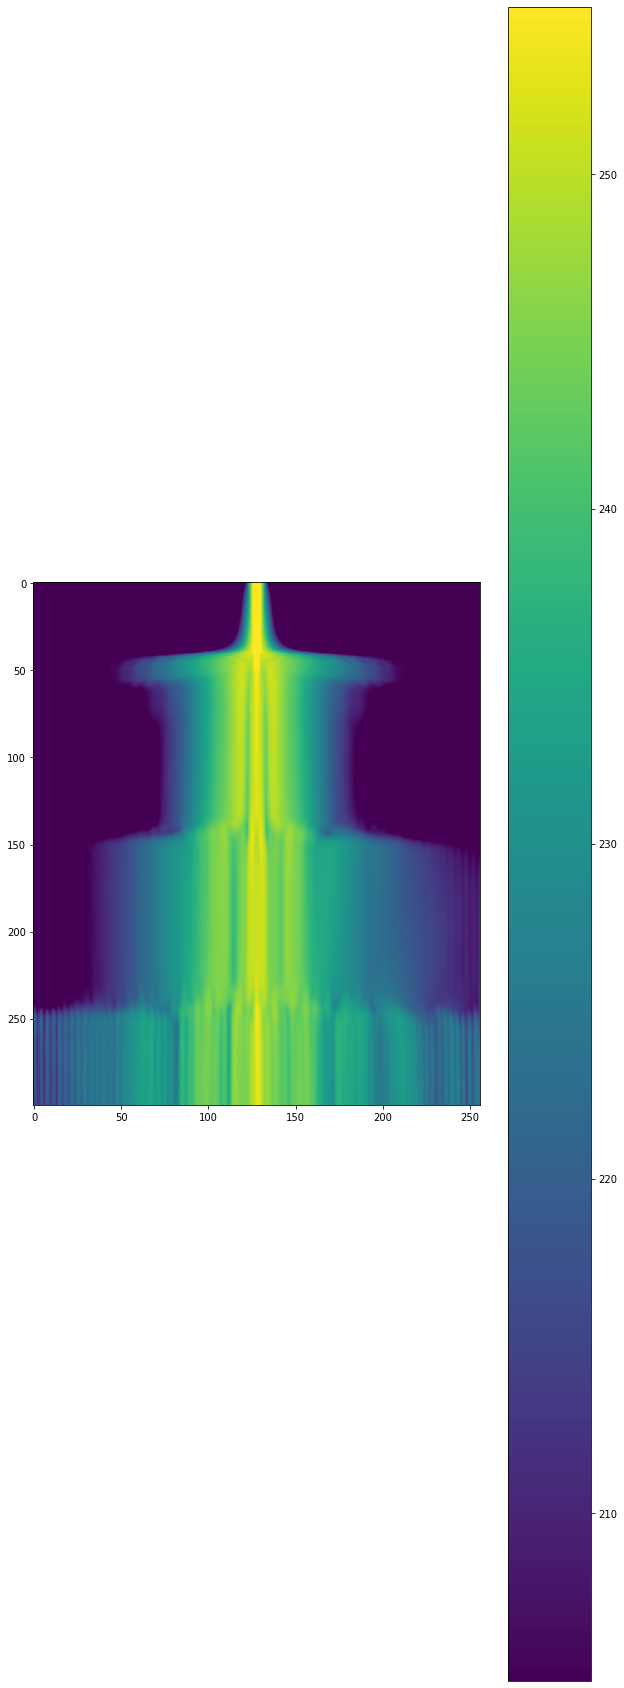

In [ ]:
plt.figure(figsize=(10, 100))
plt.imshow(10*np.log10(data_w),vmin=205, vmax=255)
#plt.imshow(data_w2)
plt.colorbar()
plt.show()

(600.0, 2000.0)

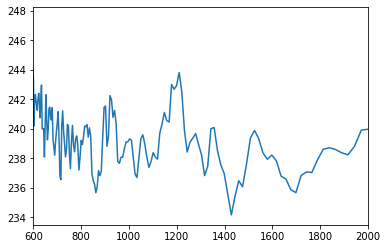

In [ ]:
plt.plot(wave*1e9,10*np.log10(data_w[2399,:]))
plt.xlim([600,2000])
#plt.ylim([600,2000])